In [ ]:
# default_exp nbeats.learner

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats Learner

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

from fastseq.nbeats.metrics import *
from fastseq.nbeats.model import *

## Learner

In [ ]:
# export
# from fastai2.basics import *
# from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataLoaders, output_channels=None, metrics=None,cbs=None, b_loss=0., loss_func=None, **kwargs):
    "Build a N-Beats style learner"  
    dbunch.after_batch.add(NormalizeTS())
    model = NBeatsNet(
        device = dbunch.train.device,
        horizon = dbunch.train.horizon,
        lookback = dbunch.train.lookback, 
        **kwargs
       )
    
    loss_func = ifnone(loss_func, F.mse_loss)
    learn = Learner(dbunch, model, loss_func=loss_func, opt_func= Adam, 
                    metrics=L(metrics)+L(mae, smape, NBeatsBackwards(),NBeatsTheta()),
                    cbs=L(NBeatsTrainer(),NBeatsAttention())+L(cbs)
                   )
    learn.lh = (dbunch.train.lookback/dbunch.train.horizon)
    return learn

# Example

In [ ]:
items = dummy_data_generator(50, 10, nrows=1000)
data = TSDataLoaders.from_items(items, horizon = 5,lookback = 15)

learn = nbeats_learner(data)
learn.lr_find()

Train:16000; Valid: 16000; Test 1000


TypeError: super(type, obj): obj must be an instance or subtype of type

epoch,train_loss,valid_loss,mae,smape,b_loss,theta,time
0,2.695028,22.104868,3.926412,1.509487,32.058422,0.186987,00:02
1,2.293382,18.819773,3.546647,1.183575,10.040125,0.031602,00:02
2,2.058022,25.928452,4.254105,1.650460,23.722204,0.052308,00:02
3,1.939290,20.452597,3.746693,1.373732,11.569510,0.037095,00:02
4,1.921337,22.520237,3.861827,1.384198,26.532722,0.045978,00:02
5,1.880250,18.742224,3.589272,1.280421,31.501259,0.046139,00:02
6,1.928364,26.685980,4.343834,1.645334,32.036892,0.053017,00:02
7,1.962457,24.022364,4.089544,1.602092,28.050898,0.053552,00:02
8,1.944078,20.109560,3.654769,1.288025,24.209656,0.065232,00:02
9,1.899723,17.075315,3.357394,1.089626,3.443317,0.065634,00:02


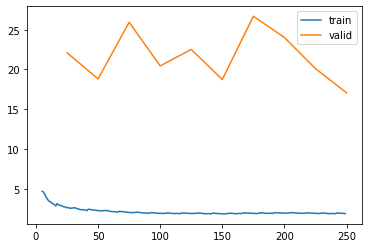

In [ ]:
learn.fit(10,.1)
learn.recorder.plot_loss()

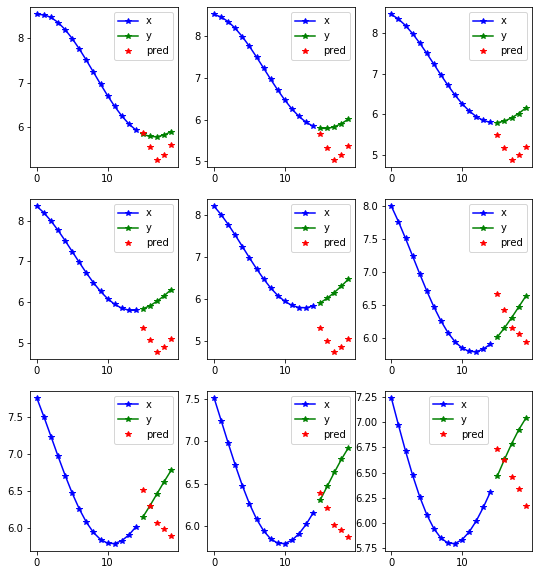

In [ ]:
learn.show_results(0)

In [ ]:
learn.n_beats_attention.means()

,trend0_0,trend0_1,trend0_2,seaonality1_0,seaonality1_1,seaonality1_2
theta_0_mean,0.030158507,-0.09999994,-0.047407907,0.5340244,0.17172885,0.6847748
theta_0_std,0.095339455,0.0,0.049849797,0.49798036,0.37993252,0.46578795
theta_1_mean,0.026253056,-0.09999994,-0.047407962,-0.53402257,-0.17172885,-0.6847748
theta_1_std,0.09642725,0.0,0.049849838,0.49798062,0.37993252,0.46578795
theta_2_mean,0.028064737,-0.028125003,-0.047407962,-0.24722561,-0.17172885,0.6847748
theta_2_std,0.09667421,0.096722074,0.049849838,0.68963945,0.37993252,0.46578795
att_mean,1,1,0.478223,0.538746,0.171806,0.686099
att_std,0,0,0.495361,0.493738,0.37711,0.462647


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted .ipynb.
Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.metrics.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted Untitled.ipynb.
Converted index.ipynb.
